In [1]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Normalization of Power Signal

Author: Clemens Jochum

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip
from src.features.normalize_power_get_pi import normalize_power_signal
from src.data.make_dataset import downsample_dataframe

In [45]:
from warnings import filterwarnings
filterwarnings('ignore')

#plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams['figure.dpi'] = 250
#'font.size': 10, 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125

### Import Datasets

Import a range of datasets for each type of synthetic data.

In [46]:
n_samples = 50
data_key = 'weather'
data_reference_key = 'soil'

path_to_data_raw = '../data/raw/'
path_to_dataset = '{0:s}/synthetic_{1:s}.zip'.format(path_to_data_raw, data_key)
path_to_dataset_reference = '{0:s}/synthetic_{1:s}.zip'.format(path_to_data_raw, data_reference_key)

In [47]:
import_df_info_from_zip(path_to_dataset).head()

,Plant,Degradation_rate_linear,Location
0,synthetic_weather_001,-0.012921,CO
1,synthetic_weather_002,-0.001933,CO
2,synthetic_weather_003,-0.009091,CO
3,synthetic_weather_004,-0.007268,CO
4,synthetic_weather_005,-0.005479,CO


In [48]:
for index in range(n_samples):
    df = import_df_from_zip_pkl(path_to_dataset, index)
    df_reference = df
        
    p_norm_daily = normalize_power_signal(df, df_reference.POA, clearsky=True, nighttime=True, clipping='basic', verbose=True, outlier_threshold = 0.70)
       
    df_pkl = downsample_dataframe(df)
    df_pkl['PI'] = p_norm_daily
    df_pkl.to_pickle('../data/raw/synthetic_{:s}_pi_daily_{:s}.pkl'.format(data_key, str(index+1).zfill(3)), compression = 'gzip', protocol = 3)

0.18 % of data remaining after clearsky detection.
0.17 % of data remaining after night-time removal.
0.13 % of data remaining after clipping removal.
0.18 % of data remaining after clearsky detection.
0.17 % of data remaining after night-time removal.
0.12 % of data remaining after clipping removal.
0.18 % of data remaining after clearsky detection.
0.17 % of data remaining after night-time removal.
0.13 % of data remaining after clipping removal.
0.17 % of data remaining after clearsky detection.
0.16 % of data remaining after night-time removal.
0.12 % of data remaining after clipping removal.
0.17 % of data remaining after clearsky detection.
0.16 % of data remaining after night-time removal.
0.11 % of data remaining after clipping removal.
0.18 % of data remaining after clearsky detection.
0.17 % of data remaining after night-time removal.
0.13 % of data remaining after clipping removal.
0.17 % of data remaining after clearsky detection.
0.16 % of data remaining after night-time r

<AxesSubplot:xlabel='datetime'>

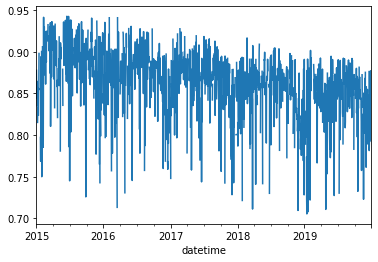

In [55]:
# test
df_pi = pd.read_pickle('../data/raw/synthetic_weather_pi_daily/synthetic_weather_pi_daily_001.pkl', compression = 'gzip')
df_pi.PI.plot()